In [ ]:
import gc
import numpy as np
import pandas as pd 
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error

In [ ]:
PRIOR_PRECISION = 10

In [ ]:
class GaussianTargetEncoder():
        
    def __init__(self, group_cols, target_col="target", prior_cols=None):
        self.group_cols = group_cols
        self.target_col = target_col
        self.prior_cols = prior_cols

    def _get_prior(self, df):
        if self.prior_cols is None:
            prior = np.full(len(df), df[self.target_col].mean())
        else:
            prior = df[self.prior_cols].mean(1)
        return prior
                    
    def fit(self, df):
        self.stats = df.assign(mu_prior=self._get_prior(df), y=df[self.target_col])
        self.stats = self.stats.groupby(self.group_cols).agg(
            n        = ("y", "count"),
            mu_mle   = ("y", np.mean),
            sig2_mle = ("y", np.var),
            mu_prior = ("mu_prior", np.mean),
        )        
    
    def transform(self, df, prior_precision=1000, stat_type="mean"):
        
        precision = prior_precision + self.stats.n/self.stats.sig2_mle
        
        if stat_type == "mean":
            numer = prior_precision*self.stats.mu_prior\
                    + self.stats.n/self.stats.sig2_mle*self.stats.mu_mle
            denom = precision
        elif stat_type == "var":
            numer = 1.0
            denom = precision
        elif stat_type == "precision":
            numer = precision
            denom = 1.0
        else: 
            raise ValueError(f"stat_type={stat_type} not recognized.")
        
        mapper = dict(zip(self.stats.index, numer / denom))
        if isinstance(self.group_cols, str):
            keys = df[self.group_cols].values.tolist()
        elif len(self.group_cols) == 1:
            keys = df[self.group_cols[0]].values.tolist()
        else:
            keys = zip(*[df[x] for x in self.group_cols])
        
        values = np.array([mapper.get(k) for k in keys]).astype(float)
        
        prior = self._get_prior(df)
        values[~np.isfinite(values)] = prior[~np.isfinite(values)]
        
        return values
    
    def fit_transform(self, df, *args, **kwargs):
        self.fit(df)
        return self.transform(df, *args, **kwargs)

In [ ]:
def rmsle(x,y):
    x = np.log1p(x)
    y = np.log1p(y)
    return np.sqrt(mean_squared_error(x, y))

In [ ]:
# load data
train = pd.read_csv("/kaggle/input/ashrae-energy-prediction/train.csv")
test  = pd.read_csv("/kaggle/input/ashrae-energy-prediction/test.csv")

In [ ]:
train.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [ ]:
# sample for kernel
train = train.sample(int(2.5e5)).reset_index(drop=True)

In [ ]:
# create target
train["target"] = np.log1p(train.meter_reading)
test["target"] = train.target.mean()

In [ ]:
# create time features
def add_time_features(df):
    df.timestamp = pd.to_datetime(df.timestamp)    
    df["hour"]    = df.timestamp.dt.hour
    df["weekday"] = df.timestamp.dt.weekday
    df["month"]   = df.timestamp.dt.month

add_time_features(train)
add_time_features(test)

In [ ]:
# define groupings and corresponding priors
groups_and_priors = {
    
    # singe encodings
    ("hour",):        None,
    ("weekday",):     None,
    ("month",):       None,
    ("building_id",): None,
    ("meter",):       None,
    
    # second-order interactions
    ("meter", "hour"):        ["gte_meter", "gte_hour"],
    ("meter", "weekday"):     ["gte_meter", "gte_weekday"],
    ("meter", "month"):       ["gte_meter", "gte_month"],
    ("meter", "building_id"): ["gte_meter", "gte_building_id"],
        
    # higher-order interactions
    ("meter", "building_id", "hour"):    ["gte_meter_building_id", "gte_meter_hour"],
    ("meter", "building_id", "weekday"): ["gte_meter_building_id", "gte_meter_weekday"],
    ("meter", "building_id", "month"):   ["gte_meter_building_id", "gte_meter_month"],
}

In [ ]:
features = []
for group_cols, prior_cols in groups_and_priors.items():
    features.append(f"gte_{'_'.join(group_cols)}")
    gte = GaussianTargetEncoder(list(group_cols), "target", prior_cols)    
    train[features[-1]] = gte.fit_transform(train, PRIOR_PRECISION)
    test[features[-1]]  = gte.transform(test,  PRIOR_PRECISION)

In [ ]:
# clean up
drop_cols = ["hour", "weekday", "month", "building_id"]
train.drop(drop_cols, 1, inplace=True)
test.drop(drop_cols, 1, inplace=True)
del  gte
gc.collect()

0

In [ ]:
train[features + ["target"]].head()

,gte_hour,gte_weekday,gte_month,gte_building_id,gte_meter,gte_meter_hour,gte_meter_weekday,gte_meter_month,gte_meter_building_id,gte_meter_building_id_hour,gte_meter_building_id_weekday,gte_meter_building_id_month,target
0,4.279481,4.186728,3.914672,5.973659,3.979259,4.081149,3.983891,3.702905,5.987308,5.789034,6.203096,6.434920,6.293992
1,3.985925,4.179150,4.358921,3.467740,3.979259,3.856025,4.016674,4.191977,3.464227,3.412267,3.629965,3.695555,3.673740
2,3.910819,4.188322,4.103846,4.739594,5.100058,4.861891,5.117617,4.812721,4.555381,4.790171,4.612680,4.451389,4.621536
3,4.032372,4.190462,4.223607,5.294614,3.979259,3.894951,4.036276,4.133564,4.143291,4.014112,4.155154,4.159478,3.962735
4,4.279481,4.202718,4.307225,5.273293,3.979259,4.081149,4.045135,4.142391,4.838701,4.903856,4.773715,4.708835,4.484132


In [ ]:
test[features].head()

,gte_hour,gte_weekday,gte_month,gte_building_id,gte_meter,gte_meter_hour,gte_meter_weekday,gte_meter_month,gte_meter_building_id,gte_meter_building_id_hour,gte_meter_building_id_weekday,gte_meter_building_id_month
0,3.985925,4.026394,3.914672,3.768381,3.979259,3.856025,3.855434,3.702905,3.664109,3.716186,3.711787,3.683507
1,3.985925,4.026394,3.914672,3.272380,3.979259,3.856025,3.855434,3.702905,3.097681,3.557044,3.457391,3.400293
2,3.985925,4.026394,3.914672,2.391197,3.979259,3.856025,3.855434,3.702905,2.196912,2.702483,2.557964,2.949909
3,3.985925,4.026394,3.914672,3.721726,3.979259,3.856025,3.855434,3.702905,3.583131,3.609893,3.679853,3.643018
4,3.985925,4.026394,3.914672,4.221420,3.979259,3.856025,3.855434,3.702905,4.194746,7.395076,4.025722,3.948826


In [ ]:
train_preds = np.zeros(len(train))
test_preds = np.zeros(len(test))

for m in range(4):
    
    print(f"Meter {m}", end="") 
    
    # instantiate model
    model = RidgeCV(
        alphas=np.logspace(-10, 1, 25), 
        normalize=True,
    )    
    
    # fit model
    model.fit(
        X=train.loc[train.meter==m, features].values, 
        y=train.loc[train.meter==m, "target"].values
    )

    # make predictions 
    train_preds[train.meter==m] = model.predict(train.loc[train.meter==m, features].values)
    test_preds[test.meter==m]   = model.predict(test.loc[test.meter==m, features].values)
    
    # transform predictions
    train_preds[train_preds < 0] = 0
    train_preds[train.meter==m] = np.expm1(train_preds[train.meter==m])
    
    test_preds[test_preds < 0] = 0 
    test_preds[test.meter==m] = np.expm1(test_preds[test.meter==m])
    
    # evaluate model
    meter_rmsle = rmsle(
        train_preds[train.meter==m],
        train.loc[train.meter==m, "meter_reading"].values
    )
    
    print(f", rmsle={meter_rmsle:0.5f}")

print(f"Overall rmsle={rmsle(train_preds, train.meter_reading.values):0.5f}")
del train, train_preds, test
gc.collect()

Meter 0, rmsle=0.78556
Meter 1, rmsle=1.34620
Meter 2, rmsle=1.44684
Meter 3, rmsle=1.43229
Overall rmsle=1.07343


0

In [ ]:
# create submission
subm  = pd.read_csv("/kaggle/input/ashrae-energy-prediction/sample_submission.csv")
subm["meter_reading"] = test_preds
subm.to_csv(f"submission.csv", index=False)

In [ ]:
from prettytable import PrettyTable
summary = PrettyTable()


summary.field_names = ["Model", "RMSE", "Meter-wise"]
summary.add_row(["bayesian-target-encoding",.785, "Meter-0"])
summary.add_row(["bayesian-target-encoding",1.34, "Meter-1"])
summary.add_row(["bayesian-target-encoding",1.44, "Meter-2"])
summary.add_row(["bayesian-target-encoding",1.43, "Meter-3"])
summary.add_row(["bayesian-target-encoding",1.43, "Overall"])
print(summary)

+--------------------------+-------+------------+
|          Model           |  RMSE | Meter-wise |
+--------------------------+-------+------------+
| bayesian-target-encoding | 0.785 |  Meter-0   |
| bayesian-target-encoding |  1.34 |  Meter-1   |
| bayesian-target-encoding |  1.44 |  Meter-2   |
| bayesian-target-encoding |  1.43 |  Meter-3   |
| bayesian-target-encoding |  1.43 |  Overall   |
+--------------------------+-------+------------+


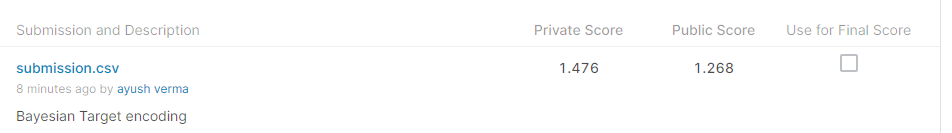

In [ ]:
from IPython.display import Image
Image(filename='/content/Bayesian Encoding 2.PNG')

### Refrences
1. https://www.kaggle.com/mmotoki/hierarchical-bayesian-target-encoding